In [58]:
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.datasets.python_splitters import python_random_split

from recommenders.evaluation.python_evaluation import (
    ndcg_at_k, precision_at_k, recall_at_k, rmse
)
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, model_selection, accuracy
from collections import defaultdict
from recommenders.models.surprise.surprise_utils import (
    predict,
    compute_ranking_predictions,
    surprise_trainset_to_df
)




In [27]:
ratings = pd.read_csv('books_data/ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books = pd.read_csv('books_data/books.csv', sep=';', error_bad_lines=False, encoding="latin-1")

C:\Users\hamza\AppData\Local\Temp\ipykernel_23716\2762359282.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv('books_data/ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
C:\Users\hamza\AppData\Local\Temp\ipykernel_23716\2762359282.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('books_data/books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 

C:\Users\hamza\AppData\Local\Temp\ipykernel_23716\3033648102.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Book-Rating", data=ratings, palette="viridis")


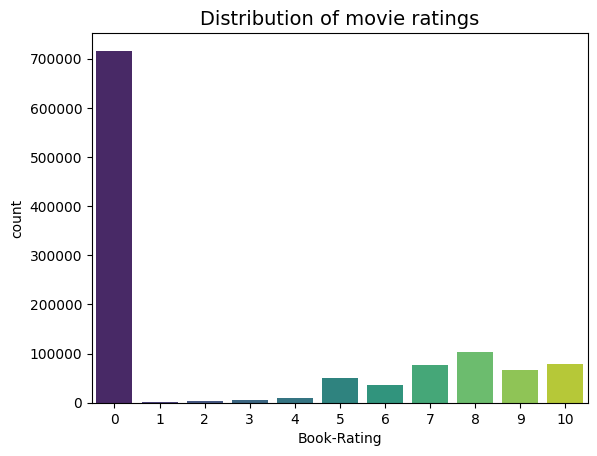

In [28]:
sns.countplot(x="Book-Rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

C:\Users\hamza\AppData\Local\Temp\ipykernel_23716\3560009944.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Book-Rating", data=ratings_explicit, palette="viridis")


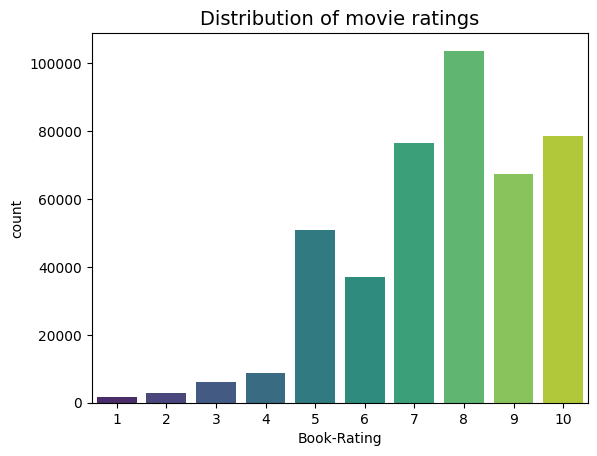

In [29]:
ratings_explicit = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=ratings_explicit, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [30]:
ratings_new = ratings_explicit[ratings_explicit.ISBN.isin(books.ISBN)]

In [33]:
books_df= pd.merge(books, ratings_new, on='ISBN')
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,67544,8
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,116866,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,123629,9


In [35]:
books_df.rename(columns = {'Book-Title':'title', 'Book-Author' : 'author', 'User-ID' : 'userID', 'Book-Rating' : 'rating','ISBN' : 'itemID'  }, inplace = True) 
books_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Year-Of-Publication', 'Publisher'], axis= 1, inplace=True)
books_df = books_df[['userID', 'itemID', 'rating', 'title', 'author']]
books_df.head()


,userID,itemID,rating,title,author
0,8,0002005018,5,Clara Callan,Richard Bruce Wright
1,11676,0002005018,8,Clara Callan,Richard Bruce Wright
2,67544,0002005018,8,Clara Callan,Richard Bruce Wright
3,116866,0002005018,9,Clara Callan,Richard Bruce Wright
4,123629,0002005018,9,Clara Callan,Richard Bruce Wright


In [42]:
user_count = books_df['userID'].value_counts()
books_df = books_df[books_df['userID'].isin(user_count[user_count >= 100].index)]

66574

In [43]:
unique_userIds = books_df['userID'].unique()
unique_userIds.sort()

# Create a mapping from old userIds to new ones (starting from 1)
user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_userIds, start=1)}

# Apply the mapping to the userIds column
books_df['userID'] = books_df['userID'].map(user_id_mapping)
books_df.sort_values(by='userID', ascending=True)

,userID,itemID,rating,title,author
138742,1,0895779129,6,"Foods That Harm, Foods That Heal: An A - Z Gu...",Reader's Digest
138332,1,0812532619,8,The Call of Earth,Orson Scott Card
138338,1,0812532635,8,The Ships of Earth : Homecoming: Volume 3 (Hom...,Orson Scott Card
138345,1,0886776589,9,"Beyond Ragnarok (Renshai Chronicles, Vol 1)",Mickey Zucker Reichert
138348,1,0886777151,9,Prince of Demons (Renshai Chronicles/Mickey Zu...,Mickey Zucker Reichert
...,...,...,...,...,...
339683,449,0399122400,4,Blind voices,Tom Reamy
97704,449,0440207622,7,Daddy,DANIELLE STEEL
336255,449,0451136683,5,"The Dark Tide (Iron Tower Trilogy, Book1)",Dennis Mckiernan
363063,449,0385320329,4,"Pig, Horse, or Cow, Don't Wake Me Now",Arlene Alda


In [44]:
unique_itemIds = books_df['itemID'].unique()

# Create a mapping from old itemIdsunique_itemIds to new ones (starting from 1)
item_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_itemIds, start=1)}

# Apply the mapping to the itemIdsunique_itemIds column
books_df['itemID'] = books_df['itemID'].map(item_id_mapping)
books_df.sort_values(by='itemID', ascending=True)

,userID,itemID,rating,title,author
1,18,1,8,Clara Callan,Richard Bruce Wright
12,184,2,10,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
15,322,2,9,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
17,18,3,9,The Kitchen God's Wife,Amy Tan
19,78,3,9,The Kitchen God's Wife,Amy Tan
...,...,...,...,...,...
383781,437,66570,7,The Banished Bride (Signet Regency Romance),Andrea Pickens
383821,440,66571,8,The Jungle Books and Just So Stories,Kipling Rudyard
383822,440,66572,6,"Off-The-Wall (Mad Libs, No. 6)",Roger Price
383823,441,66573,10,"Walking With the Great Apes: Jane Goodall, Dia...",Sy Montgomery


In [45]:
n_books = books_df['itemID'].nunique()
n_users = books_df['userID'].nunique()
n_ratings = books_df.shape[0]


print(f"Number of ratings: {n_ratings}")
print(f"Number of unique books's: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per book: {round(n_ratings/n_books, 2)}")





Number of ratings: 103271
Number of unique books's: 66574
Number of unique users: 449
Average number of ratings per user: 230.0
Average number of ratings per book: 1.55


In [48]:
books_df['title'].value_counts()[0:10]

Harry Potter and the Chamber of Secrets (Book 2)      72
The Lovely Bones: A Novel                             71
Bridget Jones's Diary                                 64
Harry Potter and the Prisoner of Azkaban (Book 3)     58
Harry Potter and the Goblet of Fire (Book 4)          54
To Kill a Mockingbird                                 52
The Da Vinci Code                                     51
The Secret Life of Bees                               48
Harry Potter and the Order of the Phoenix (Book 5)    46
The Firm                                              46
Name: title, dtype: int64

In [49]:
print(f"Mean global rating: {round(books_df['rating'].mean(),2)}.")

mean_ratings = books_df.groupby('userID')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 7.83.
Mean rating per user: 7.84.


In [50]:
count = books_df['title'].count()
unique = books_df['title'].nunique()

print(f"There are {count} books and {unique} unique books")

There are 103271 books and 61649 unique books


In [51]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(books_df[['userID', 'itemID', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)


model = SVD()
model.fit(trainset)

In [52]:
test_df = pd.DataFrame(testset, columns=['userID', 'itemID', 'rating'])


In [53]:
trainset, testset = train_test_split(data, test_size=0.25)
model = SVD()
model.fit(trainset)

In [54]:
test_df = pd.DataFrame(testset, columns=['userID', 'itemID', 'rating'])

In [55]:
predictions = predict(model, test_df, usercol="userID", itemcol="itemID")
predictions.head()

,userID,itemID,prediction
0,216,57545,9.006209
1,96,37387,6.747801
2,365,9472,8.094504
3,161,14320,9.165224
4,161,3093,8.917582


In [56]:
train_df = surprise_trainset_to_df(trainset,col_user="userID", col_item="itemID")

In [61]:
def compute_ranking_predictions_custom(
    algo,
    data,
    usercol= "userID",
    itemcol="itemID",
    predcol="prediction",
    remove_seen=False,
):
    """Computes predictions of an algorithm from Surprise on all users and items in data. It can be used for computing
    ranking metrics like NDCG.

    Args:
        algo (surprise.prediction_algorithms.algo_base.AlgoBase): an algorithm from Surprise
        data (pandas.DataFrame): the data from which to get the users and items
        usercol (str): name of the user column
        itemcol (str): name of the item column
        remove_seen (bool): flag to remove (user, item) pairs seen in the training data

    Returns:
        pandas.DataFrame: Dataframe with usercol, itemcol, predcol
    """

    preds_lst = []
    users = data[usercol].unique()
    items = data[itemcol].unique()

    total_users = len(users)
    print_interval = 20  # Print progress every 20 users

    
    for index, user in enumerate(users):
        for item in items:
            preds_lst.append([user, item, algo.predict(user, item).est])

        if (index + 1) % print_interval == 0:
            print(f"Progress: {index + 1}/{total_users}")

    all_predictions = pd.DataFrame(data=preds_lst, columns=[usercol, itemcol, predcol])

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [63]:
all_predictions = compute_ranking_predictions_custom(
    model, train_df, usercol="userID", itemcol="itemID", remove_seen=True
)

test


KeyboardInterrupt: 

In [ ]:
eval_ndcg = ndcg_at_k(test_df, all_predictions, col_prediction='prediction', k=10)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=10)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=10)
eval_rmse = rmse(test, predictions2)


print(
      "RMSE:\t\t%f" % eval_rmse,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n'
      )

In [ ]:
def calculate_f1_score(precision_at_k, recall_at_k):
    """
    Calculate the F1 score from Precision@K and Recall@K.

    Args:
        precision_at_k (float): Precision at K.
        recall_at_k (float): Recall at K.

    Returns:
        float: The F1 score calculated from Precision@K and Recall@K.
    """
    # Check for cases where both precision and recall are zero.
    if precision_at_k + recall_at_k == 0:
        return 0.0
    
    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    return f1_score

In [ ]:
f1_score = calculate_f1_score(eval_precision, eval_recall)
print(f"F1 Score: {f1_score}")